##### Code 1: Quantum Inventory Dynamics

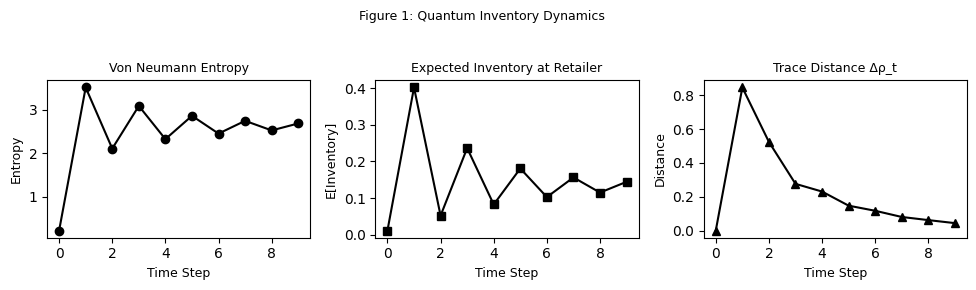

In [2]:
            import numpy as np
            import matplotlib.pyplot as plt
            from scipy.linalg import sqrtm

            ###### -- Step 1: System Setup --
            dim = 3  # Inventory levels: Low, Medium, High
            I = np.eye(dim)
            basis = [np.eye(dim)[:, i].reshape(-1, 1) for i in range(dim)]

            ######  Initial joint state |111⟩
            psi0 = np.kron(np.kron(basis[1], basis[1]), basis[1])
            rho = psi0 @ psi0.T  # 27x27 density matrix

            ######  -- Step 2: Define Kraus Operators --
            K_demand = np.array([[0, 1, 0],
                                [0, 0, 1],
                                [0, 0, 0]])

            K_restock = np.array([[0, 0, 0],
                                [1, 0, 0],
                                [0, 1, 0]])

            def depolarize(rho, p):
                d = rho.shape[0]
                return (1 - p) * rho + p * np.eye(d) / d

            ######  Observable operator for expected inventory at Retailer
            O_inventory = np.diag([0, 1, 2])
            O_R = np.kron(np.kron(I, I), O_inventory)

            ######  -- Step 3: Measurement Functions --
            def von_neumann_entropy(rho):
                eigvals = np.linalg.eigvalsh(rho)
                eigvals = eigvals[eigvals > 1e-10]
                return -np.sum(eigvals * np.log2(eigvals))

            def trace_distance(rho1, rho2):
                delta = rho1 - rho2
                return 0.5 * np.trace(sqrtm(delta.conj().T @ delta)).real

            ######  -- Step 4: Simulation Loop --
            n_steps = 10
            entropy_list = []
            expected_inv = []
            trace_dist = []

            for t in range(n_steps):
                rho_prev = rho.copy()

                # Depolarizing noise
                rho = depolarize(rho, p=0.05)

                # Demand shock at Retailer
                Kd_full = np.kron(np.kron(I, I), K_demand)
                rho = Kd_full @ rho @ Kd_full.T
                rho /= np.trace(rho)

                # Replenishment from Distributor
                Kr_full = np.kron(np.kron(I, K_restock), I)
                rho = Kr_full @ rho @ Kr_full.T
                rho /= np.trace(rho)

                # Metrics
                entropy_list.append(von_neumann_entropy(rho))
                expected_inv.append(np.trace(rho @ O_R).real)
                if t > 0:
                    trace_dist.append(trace_distance(rho, rho_prev))

            ######  -- Step 5: Plot Results with Figure Title --
            plt.figure(figsize=(10, 3))
            plt.suptitle("Figure 1: Quantum Inventory Dynamics", fontsize=9)


            plt.subplot(1, 3, 1)
            plt.plot(entropy_list, marker='o',color='black')
            plt.title("Von Neumann Entropy", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("Entropy",fontsize=9)

            plt.subplot(1, 3, 2)
            plt.plot(expected_inv, marker='s', color='black')
            plt.title("Expected Inventory at Retailer", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("E[Inventory]",fontsize=9)

            plt.subplot(1, 3, 3)
            plt.plot([0] + trace_dist, marker='^', color='black')
            plt.title("Trace Distance Δρ_t", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("Distance",fontsize=9)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
    

##### Code 2:Quantum Inventory Dynamics with Lead Time, Noise, Feedback

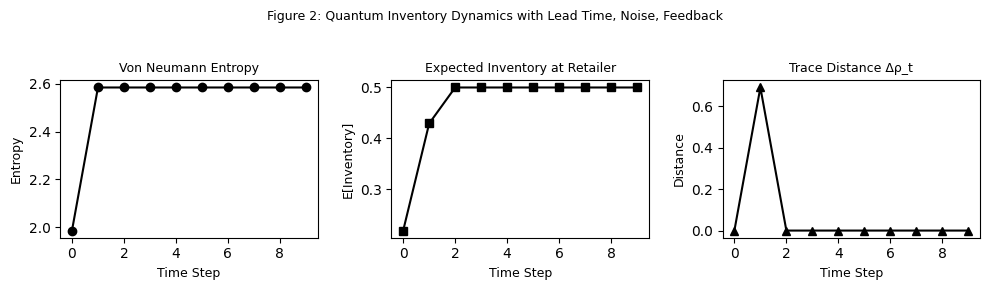

In [4]:
            import numpy as np
            import matplotlib.pyplot as plt
            from scipy.linalg import sqrtm

            ###### --- Configurable Parameters ---
            dim = 3  # Inventory levels: Low, Medium, High
            n_nodes = 3  # Chain: Supplier → Distributor → Retailer
            I = np.eye(dim)

            ######  Demand volatility: varies over time
            demand_strength_schedule = np.linspace(1.0, 0.6, 10)

            ######  Initial state: |1⟩⊗|1⟩⊗|1⟩
            basis = [np.eye(dim)[:, i].reshape(-1, 1) for i in range(dim)]
            psi0 = basis[1]
            for _ in range(n_nodes - 1):
                psi0 = np.kron(psi0, basis[1])
            rho = psi0 @ psi0.T  # Initial density matrix

            ######  --- Kraus Operators ---
            K_demand_base = np.array([[0, 1, 0],
                                    [0, 0, 1],
                                    [0, 0, 0]])

            K_restock = np.array([[0, 0, 0],
                                [1, 0, 0],
                                [0, 1, 0]])

            def apply_depolarizing_noise(rho, p, node_index):
                d = dim ** n_nodes
                noise_matrix = np.eye(dim) / dim
                full_op = [I] * n_nodes
                full_op[node_index] = noise_matrix
                noise_op = full_op[0]
                for mat in full_op[1:]:
                    noise_op = np.kron(noise_op, mat)
                return (1 - p) * rho + p * noise_op

            def von_neumann_entropy(rho):
                eigvals = np.linalg.eigvalsh(rho)
                eigvals = eigvals[eigvals > 1e-10]
                return -np.sum(eigvals * np.log2(eigvals))

            def trace_distance(rho1, rho2):
                delta = rho1 - rho2
                return 0.5 * np.trace(sqrtm(delta.conj().T @ delta)).real

            ######  Observable: Expected inventory at Retailer
            O_inventory = np.diag([0, 1, 2])
            O_R = O_inventory
            for _ in range(n_nodes - 1):
                O_R = np.kron(I, O_R)

            ######  --- Simulation Parameters ---
            n_steps = 10
            entropy_list = []
            expected_inv = []
            trace_dist = []
            lead_time_buffer = [None] * 1  # Lead time delay of 1 step

            for t in range(n_steps):
                rho_prev = rho.copy()

                # Step 1: Node-specific noise
                for node_idx in range(n_nodes):
                    rho = apply_depolarizing_noise(rho, p=0.03 + 0.01 * node_idx, node_index=node_idx)

                # Step 2: Demand shock at Retailer
                demand_strength = demand_strength_schedule[t]
                K_demand = demand_strength * K_demand_base
                Kd_full = K_demand
                for _ in range(n_nodes - 1):
                    Kd_full = np.kron(I, Kd_full)
                rho = Kd_full @ rho @ Kd_full.T
                rho /= np.trace(rho)

                # Step 3: Store restock operation for delayed execution
                Kr_full = K_restock
                for _ in range(n_nodes - 2):
                    Kr_full = np.kron(I, Kr_full)
                Kr_full = np.kron(Kr_full, I)
                lead_time_buffer.append(Kr_full)

                # Step 4: Apply replenishment from buffer
                Kr_delayed = lead_time_buffer.pop(0)
                if Kr_delayed is not None:
                    rho = Kr_delayed @ rho @ Kr_delayed.T
                    rho /= np.trace(rho)

                # Step 5: Feedback: boost distributor if retailer stock low
                E_inv = np.trace(rho @ O_R).real
                if E_inv < 0.8:
                    Kr_boosted = 1.5 * K_restock
                    Kr_feedback = Kr_boosted
                    for _ in range(n_nodes - 2):
                        Kr_feedback = np.kron(I, Kr_feedback)
                    Kr_feedback = np.kron(Kr_feedback, I)
                    rho = Kr_feedback @ rho @ Kr_feedback.T
                    rho /= np.trace(rho)

                # Record metrics
                entropy_list.append(von_neumann_entropy(rho))
                expected_inv.append(E_inv)
                if t > 0:
                    trace_dist.append(trace_distance(rho, rho_prev))

            ######  --- Plot Results ---
            plt.figure(figsize=(10, 3))
            plt.suptitle("Figure 2: Quantum Inventory Dynamics with Lead Time, Noise, Feedback", fontsize=9)

            plt.subplot(1, 3, 1)
            plt.plot(entropy_list, marker='o',color='black')
            plt.title("Von Neumann Entropy", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("Entropy",fontsize=9)

            plt.subplot(1, 3, 2)
            plt.plot(expected_inv, marker='s', color='black')
            plt.title("Expected Inventory at Retailer", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("E[Inventory]",fontsize=9)

            plt.subplot(1, 3, 3)
            plt.plot([0] + trace_dist, marker='^', color='black')
            plt.title("Trace Distance Δρ_t", fontsize=9)
            plt.xlabel("Time Step",fontsize=9)
            plt.ylabel("Distance",fontsize=9)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
